# Flux comparison
In FIG. 4 , the authors compared subsystems by selecting the most de-regulated reactions across cell types (LG and HG). I think They optimized to max biomass each of the 7 models  (they generated 7 FBA solutions) and then they computed the average of each flux across cell lines of the same family.

However, they selected one of the many solutions that respect max biomass growth. I suggest to:

1. Impose biomass at its upper bound for each model (LB = UB*0.90 to avoid solver numerical issues)
2. Run flux sampling with OPTGP (cobrapy) with thinning = 100 and 1k samples per cell line
3. DO not 'summarize' flux probability distributions with a simple average, but use more advanced methods. The objective here is to identify the most different reactions across the two cancer families. You could run non parametric statistical tests such as mann-whitney to check if two probability distributions are significantly different or not. You have 3 cells vs 2 cells (all pair combinations), so you could perform this test only on reactions belonging to core subsystems such as glycolysis, TCA cycle pentophosphate etc.. in order to redure the number of compared distribution per cell couple.
4. Once you identified the top-n most different probability distributions (reaction fluxes) across cells of different type, you could plot them with boxplots as the authors did 
5. It might be interesting to check if we have 'less differences' in distributions of cells belonging to the same family.

In [1]:
from cobra.sampling import sample
import pandas as pd
import numpy as np
import pandas as pd
from cobra.io.json import load_json_model
import numpy as np
from cobra.flux_analysis import flux_variability_analysis
import os


In [2]:
model = load_json_model('./data/Recon3D.json')
model.solver = 'gurobi'
model.objective = 'BIOMASS_reaction'

Set parameter Username
Set parameter LicenseID to value 2732841
Academic license - for non-commercial use only - expires 2026-11-04


# Seperating reactions into pathways

In [64]:
subsystem_dict = {}

for r in model.reactions:
    # get subsystem safely
    s = (getattr(r, "subsystem", "") or "").strip()

    # if it contains "/", keep only the first part
    if "/" in s:
        s = s.split("/")[0].strip()   # take text before "/" and remove spaces

    s = s.lower()

    # skip empty subsystems
    if not s:
        continue

    # add reaction to that subsystem list
    subsystem_dict.setdefault(s, []).append(r.id)
subsystem_dict.keys()

dict_keys(['transport, mitochondrial', 'transport, extracellular', 'transport, lysosomal', 'extracellular exchange', 'vitamin d metabolism', 'transport, endoplasmic reticular', 'beta-alanine metabolism', 'glycine, serine, alanine, and threonine metabolism', 'methionine and cysteine metabolism', 'lysine metabolism', 'tryptophan metabolism', 'tyrosine metabolism', 'ubiquinone synthesis', 'taurine and hypotaurine metabolism', 'cytochrome metabolism', 'steroid metabolism', 'sphingolipid metabolism', 'o-glycan metabolism', 'blood group synthesis', 'glutamate metabolism', 'valine, leucine, and isoleucine metabolism', 'fatty acid oxidation', 'transport, peroxisomal', 'propanoate metabolism', 'transport, golgi apparatus', 'aminosugar metabolism', 'transport, nuclear', 'urea cycle', 'citric acid cycle', 'vitamin b2 metabolism', 'nucleotide interconversion', 'arginine and proline metabolism', 'purine synthesis', 'keratan sulfate synthesis', 'alanine and aspartate metabolism', 'n-glycan degradati

In [4]:
category_keywords = {
    "Glycolysis": [
        "glycolysis", "gluconeogenesis"
    ],
    
    "TCA": [
        "tca", "citric acid", "krebs"
    ],
    
    "Pentose Phosphate Pathway": [
        "pentose phosphate", "ppp"
    ],
    
    "Amino acid metabolism": [
        "amino acid",
        "tyrosine", "phenylalanine", "tryptophan",
        "lysine", "leucine", "isoleucine", "valine",
        "methionine", "cysteine", "serine", "threonine",
        "histidine", "arginine", "ornithine", "proline",
        "glutamate", "glutamine", "aspartate", "asparagine",
        "alanine", "glycine"
    ],
    
    "Nucleotide metabolism": [
        "nucleotide", "purine", "pyrimidine", "deoxynucleotide", "dntp"
    ],
    
    "Fatty acid metabolism": [
        "fatty acid", "beta oxidation", "beta-oxidation",
        "acyl", "acyl-coa"
    ],
    
    "Lipid metabolism": [
        "lipid", "phospholipid", "sphingolipid", "glycerolipid"
    ],
}

In [5]:
keys = list(subsystem_dict.keys())
print(keys)

['transport, mitochondrial', 'transport, extracellular', 'transport, lysosomal', 'extracellular exchange', 'vitamin d metabolism', 'transport, endoplasmic reticular', 'beta-alanine metabolism', 'glycine, serine, alanine, and threonine metabolism', 'methionine and cysteine metabolism', 'lysine metabolism', 'tryptophan metabolism', 'tyrosine metabolism', 'ubiquinone synthesis', 'taurine and hypotaurine metabolism', 'cytochrome metabolism', 'steroid metabolism', 'sphingolipid metabolism', 'o-glycan metabolism', 'blood group synthesis', 'glutamate metabolism', 'valine, leucine, and isoleucine metabolism', 'fatty acid oxidation', 'transport, peroxisomal', 'propanoate metabolism', 'transport, golgi apparatus', 'aminosugar metabolism', 'transport, nuclear', 'urea cycle', 'citric acid cycle', 'vitamin b2 metabolism', 'nucleotide interconversion', 'arginine and proline metabolism', 'purine synthesis', 'keratan sulfate synthesis', 'alanine and aspartate metabolism', 'n-glycan degradation', 'bile

In [6]:
selected = {cat: [] for cat in category_keywords}

In [7]:
for subsystem_name, rxns in subsystem_dict.items():
    name_lower = subsystem_name.lower()

    for category, keywords in category_keywords.items():
        if any(kw in name_lower for kw in keywords):
            selected[category].extend(rxns)

In [8]:
for cat, rxns in selected.items():
    print(f"{cat}: {len(set(rxns))} reactions")

Glycolysis: 42 reactions
TCA: 20 reactions
Pentose Phosphate Pathway: 41 reactions
Amino acid metabolism: 439 reactions
Nucleotide metabolism: 273 reactions
Fatty acid metabolism: 1200 reactions
Lipid metabolism: 369 reactions


In [9]:
for rxn_id in selected["Lipid metabolism"]:
    rxn = model.reactions.get_by_id(rxn_id)
    print(rxn_id, " → ", rxn.subsystem)

A4GALTc  →  Sphingolipid metabolism
A4GALTg  →  Sphingolipid metabolism
B3GALT3g  →  Sphingolipid metabolism
B3GALT42g  →  Sphingolipid metabolism
B3GNT31g  →  Sphingolipid metabolism
B3GNT34g  →  Sphingolipid metabolism
B3GNT37g  →  Sphingolipid metabolism
B3GNT39g  →  Sphingolipid metabolism
DHCRD2  →  Sphingolipid metabolism
DSAT  →  Sphingolipid metabolism
GALGT2  →  Sphingolipid metabolism
GALGT3  →  Sphingolipid metabolism
GAO1g  →  Sphingolipid metabolism
GBA  →  Sphingolipid metabolism
GBGT1  →  Sphingolipid metabolism
GLAl  →  Sphingolipid metabolism
GLB1  →  Sphingolipid metabolism
NAGAlby  →  Sphingolipid metabolism
SBPP3er  →  Sphingolipid metabolism
SGPL12r  →  Sphingolipid metabolism
SLCBK1  →  Sphingolipid metabolism
SMPD3g  →  Sphingolipid metabolism
SMS  →  Sphingolipid metabolism
SPHK21c  →  Sphingolipid metabolism
ST3GAL21g  →  Sphingolipid metabolism
ST3GAL22g  →  Sphingolipid metabolism
ST3GAL23g  →  Sphingolipid metabolism
ST6GALNAC21  →  Sphingolipid metabolism
S

In [66]:
reactions_by_category = {
    "glycolysis": selected["Glycolysis"],
    "tca": selected["TCA"],
    "ppp": selected["Pentose Phosphate Pathway"],
    "amino_acid": selected["Amino acid metabolism"],
    "nucleotide": selected["Nucleotide metabolism"],
    "fatty_acid": selected["Fatty acid metabolism"],
    "lipid": selected["Lipid metabolism"],

}

reactions_by_category.keys()

dict_keys(['glycolysis', 'tca', 'ppp', 'amino_acid', 'nucleotide', 'fatty_acid', 'lipid'])

- index = rxn_id
- columns = cell_id

# Flux sampling

In [11]:
low_grade = {
    'ACH-000520': '59M',
    'ACH-000542': 'HEYA8',
    'ACH-000091': 'OV56'
}
high_grade = {
    'ACH-000256': 'COV318',
    'ACH-000713': 'CAOV3',
    'ACH-000116': 'OAW28'
}

In [12]:
"""os.makedirs("data/flux_sampling_data_new", exist_ok=True)"""

'os.makedirs("data/flux_sampling_data_new", exist_ok=True)'

In [13]:
def run_sampling_for_group(group_dict, suffix):
    for cl_id, cl_name in group_dict.items():
        print(f"\n=== Processing {cl_name} ({cl_id}) — {suffix} ===")

        # Load FVA file
        fva_path = f'./data/fva_rnaseq_{cl_id}_{suffix}.csv'
        df_fva = pd.read_csv(fva_path, index_col=0)

        # Clean invalid or missing bounds
        df_fva[['minimum', 'maximum']] = df_fva[['minimum', 'maximum']].fillna(0.0)
        invalid = df_fva['minimum'] > df_fva['maximum']
        df_fva.loc[invalid, ['minimum', 'maximum']] = 0.0

        #  Inject reaction bounds into model
        for rxn_id, row in df_fva.iterrows():
            model.reactions.get_by_id(rxn_id).bounds = (row['minimum'], row['maximum'])

        # Check feasibility
        sol = model.optimize()
        print(f"   Status: {sol.status}, Growth: {sol.objective_value}")

        #  Fix biomass at 90% of UB
        UB = model.reactions.get_by_id('BIOMASS_reaction').upper_bound
        model.reactions.get_by_id('BIOMASS_reaction').bounds = (0.9 * UB, UB)

        # 7) Run flux sampling
        print("   Running OPTGP sampling...")
        samples = sample(model, n=1000, method="optgp", thinning=100, seed=42)

        # 8) Save CSV
        out_path = f"./data/flux_sampling_data/flux_samples_{cl_name}_{suffix}.csv"
        samples.to_csv(out_path)

        print(f"   Saved → {out_path}")

In [14]:
"""run_sampling_for_group(low_grade, "LG")
run_sampling_for_group(high_grade, "HG")"""

'run_sampling_for_group(low_grade, "LG")\nrun_sampling_for_group(high_grade, "HG")'

# Flux Distribution comparisions

In [11]:
"""LG = {
    "59M": pd.read_csv("./data/flux_sampling_data/flux_sampling_LG_59M.csv", index_col=0),
    "HEYA8": pd.read_csv("./data/flux_sampling_data/flux_sampling_LG_HEYA8.csv", index_col=0),
    "OV56": pd.read_csv("./data/flux_sampling_data/flux_sampling_LG_OV56.csv", index_col=0)
}

HG = {
    "COV318": pd.read_csv("./data/flux_sampling_data/flux_sampling_HG_COV318.csv", index_col=0),
    "CAOV3": pd.read_csv("./data/flux_sampling_data/flux_sampling_HG_CAOV3.csv", index_col=0),
    "OAW28": pd.read_csv("./data/flux_sampling_data/flux_sampling_HG_OAW28.csv", index_col=0)
}"""

LG = {
    "59M": pd.read_csv("data/flux_sampling_data/flux_sampling_LG_59M.csv", index_col=0),
    "HEYA8": pd.read_csv("data/flux_sampling_data/flux_sampling_LG_HEYA8.csv", index_col=0),
    "OV56": pd.read_csv("data/flux_sampling_data/flux_sampling_LG_OV56.csv", index_col=0)
}

HG = {
    "COV318": pd.read_csv("data/flux_sampling_data/flux_sampling_HG_COV318.csv", index_col=0),
    "CAOV3": pd.read_csv("data/flux_sampling_data/flux_sampling_HG_CAOV3.csv", index_col=0),
    "OAW28": pd.read_csv("data/flux_sampling_data/flux_sampling_HG_OAW28.csv", index_col=0)
}

## Option 1

In [12]:
rxns = reactions_by_category["glycolysis"]

In [14]:
from scipy.stats import mannwhitneyu

results = []

for rxn in rxns:
    for lg_name, lg_df in LG.items():
        for hg_name, hg_df in HG.items():
            
            # extract distributions
            lg_values = lg_df[rxn].dropna()
            hg_values = hg_df[rxn].dropna()
            
            if len(lg_values) == 0 or len(hg_values) == 0:
                continue
            
            # Mann-Whitney test (non-parametric, distribution vs distribution)
            stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")
            
            results.append([rxn, lg_name, hg_name, stat, pval])


In [15]:
df_stats = pd.DataFrame(results, columns=["reaction", "LG", "HG", "U_stat", "p_value"])

In [16]:
df_stats

,reaction,LG,HG,U_stat,p_value
0,ALCD2y,59M,COV318,0.0,0.000000
1,ALCD2y,59M,CAOV3,0.0,0.000000
2,ALCD2y,59M,OAW28,2213.0,0.000000
3,ALCD2y,HEYA8,COV318,0.0,0.000000
4,ALCD2y,HEYA8,CAOV3,0.0,0.000000
...,...,...,...,...,...
373,AGPOP,HEYA8,CAOV3,0.0,0.000000
374,AGPOP,HEYA8,OAW28,331.0,0.000000
375,AGPOP,OV56,COV318,0.0,0.000000
376,AGPOP,OV56,CAOV3,1023.0,0.000000


In [18]:
from statsmodels.stats.multitest import multipletests

df_stats["p_adjusted"] = multipletests(df_stats["p_value"], method="fdr_bh")[1]

In [19]:
signif = df_stats[df_stats["p_adjusted"] < 0.01]
freq = signif.groupby("reaction").size().sort_values(ascending=False)

In [20]:
signif_sorted = signif.sort_values(by="p_adjusted", ascending=True)
print(signif_sorted)

    reaction     LG      HG     U_stat   p_value  p_adjusted
370    AGPOP    59M   CAOV3        0.0  0.000000    0.000000
5     ALCD2y  HEYA8   OAW28     8822.0  0.000000    0.000000
255      PGI  HEYA8  COV318   992316.0  0.000000    0.000000
256      PGI  HEYA8   CAOV3  1000000.0  0.000000    0.000000
8     ALCD2y   OV56   OAW28   997240.0  0.000000    0.000000
..       ...    ...     ...        ...       ...         ...
92     r0355    59M   OAW28   541346.0  0.001366    0.001399
195     ACSm   OV56  COV318   541235.0  0.001407    0.001437
306   G3PD2m    59M  COV318   459964.0  0.001933    0.001969
139   ALDD2x  HEYA8   CAOV3   463435.0  0.004632    0.004707
204   ALCD2x   OV56  COV318   535385.0  0.006140    0.006223

[373 rows x 6 columns]


## Option 2

In [21]:
results_2 = []

for rxn in rxns:
    for lg_name, lg_df in LG.items():
        for hg_name, hg_df in HG.items():
            
            # extract distributions
            lg_values = lg_df[rxn].dropna()
            hg_values = hg_df[rxn].dropna()
            
            # skip if empty
            if len(lg_values) == 0 or len(hg_values) == 0:
                continue
            
            # mean flux values
            mean_lg = lg_values.mean()
            mean_hg = hg_values.mean()
            
            # ---- Fold Difference (FD) ----
            # FD = | (mean_lg - mean_hg) / mean_hg |
            if mean_hg == 0:
                FD = np.nan  # avoid division by zero
            else:
                FD = abs((mean_lg - mean_hg) / mean_hg)
            
            # ---- Mann–Whitney U Test ----
            stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")
            
            results_2.append([
                rxn, lg_name, hg_name,
                stat, pval, mean_lg, mean_hg, FD
            ])

df_stats_2 = pd.DataFrame(results_2, columns=[
    "reaction", "LG", "HG",
    "U_stat", "p_value",
    "mean_LG", "mean_HG", "fold_change"
])

In [22]:
df_stats_2

,reaction,LG,HG,U_stat,p_value,mean_LG,mean_HG,fold_change
0,ALCD2y,59M,COV318,0.0,0.000000,1.708023e-08,4.937532e-08,0.654073
1,ALCD2y,59M,CAOV3,0.0,0.000000,1.708023e-08,5.664380e-08,0.698462
2,ALCD2y,59M,OAW28,2213.0,0.000000,1.708023e-08,4.213798e-08,0.594659
3,ALCD2y,HEYA8,COV318,0.0,0.000000,2.696971e-08,4.937532e-08,0.453782
4,ALCD2y,HEYA8,CAOV3,0.0,0.000000,2.696971e-08,5.664380e-08,0.523872
...,...,...,...,...,...,...,...,...
373,AGPOP,HEYA8,CAOV3,0.0,0.000000,1.659835e+02,3.184086e+02,0.478709
374,AGPOP,HEYA8,OAW28,331.0,0.000000,1.659835e+02,2.513565e+02,0.339649
375,AGPOP,OV56,COV318,0.0,0.000000,2.472524e+02,4.355200e+02,0.432282
376,AGPOP,OV56,CAOV3,1023.0,0.000000,2.472524e+02,3.184086e+02,0.223475


In [23]:
df_stats_2["p_adjusted"] = multipletests(df_stats_2["p_value"], method="fdr_bh")[1]

In [24]:
signif = df_stats_2[df_stats_2["p_adjusted"] < 0.01]
signif

,reaction,LG,HG,U_stat,p_value,mean_LG,mean_HG,fold_change,p_adjusted
0,ALCD2y,59M,COV318,0.0,0.000000,1.708023e-08,4.937532e-08,0.654073,0.000000
1,ALCD2y,59M,CAOV3,0.0,0.000000,1.708023e-08,5.664380e-08,0.698462,0.000000
2,ALCD2y,59M,OAW28,2213.0,0.000000,1.708023e-08,4.213798e-08,0.594659,0.000000
3,ALCD2y,HEYA8,COV318,0.0,0.000000,2.696971e-08,4.937532e-08,0.453782,0.000000
4,ALCD2y,HEYA8,CAOV3,0.0,0.000000,2.696971e-08,5.664380e-08,0.523872,0.000000
...,...,...,...,...,...,...,...,...,...
373,AGPOP,HEYA8,CAOV3,0.0,0.000000,1.659835e+02,3.184086e+02,0.478709,0.000000
374,AGPOP,HEYA8,OAW28,331.0,0.000000,1.659835e+02,2.513565e+02,0.339649,0.000000
375,AGPOP,OV56,COV318,0.0,0.000000,2.472524e+02,4.355200e+02,0.432282,0.000000
376,AGPOP,OV56,CAOV3,1023.0,0.000000,2.472524e+02,3.184086e+02,0.223475,0.000000


In [25]:
# 50% cutoff = FD >= 0.50
signif_50 = df_stats_2[df_stats_2["fold_change"] >= 0.2]
signif_50


,reaction,LG,HG,U_stat,p_value,mean_LG,mean_HG,fold_change,p_adjusted
0,ALCD2y,59M,COV318,0.0,0.0,1.708023e-08,4.937532e-08,0.654073,0.0
1,ALCD2y,59M,CAOV3,0.0,0.0,1.708023e-08,5.664380e-08,0.698462,0.0
2,ALCD2y,59M,OAW28,2213.0,0.0,1.708023e-08,4.213798e-08,0.594659,0.0
3,ALCD2y,HEYA8,COV318,0.0,0.0,2.696971e-08,4.937532e-08,0.453782,0.0
4,ALCD2y,HEYA8,CAOV3,0.0,0.0,2.696971e-08,5.664380e-08,0.523872,0.0
...,...,...,...,...,...,...,...,...,...
372,AGPOP,HEYA8,COV318,0.0,0.0,1.659835e+02,4.355200e+02,0.618884,0.0
373,AGPOP,HEYA8,CAOV3,0.0,0.0,1.659835e+02,3.184086e+02,0.478709,0.0
374,AGPOP,HEYA8,OAW28,331.0,0.0,1.659835e+02,2.513565e+02,0.339649,0.0
375,AGPOP,OV56,COV318,0.0,0.0,2.472524e+02,4.355200e+02,0.432282,0.0


## Option 3

In [26]:
# Statistical Threshold (Adjusted P-value / Q-value)
FDR_Q_VALUE_CUTOFF = 0.01
# Effect Size Threshold (Log2 Fold Change equivalent to your 20% change)
LOG2_FC_CUTOFF = 0.26 

all_results_data = []

for rxn in rxns:
    for lg_name, lg_df in LG.items():
        for hg_name, hg_df in HG.items():
            
            # extract distributions
            lg_values = lg_df[rxn].dropna()
            hg_values = hg_df[rxn].dropna()
            
            if len(lg_values) < 3 or len(hg_values) < 3:
                # Skip if too few observations for robust test
                continue
            
            # Calculate the means for log2FC calculation
            mean_lg = lg_values.mean()
            mean_hg = hg_values.mean()

            # Handle division by zero for log2FC: use a small pseudo-count or check for zero
            # Here, we check for near-zero means for stability (a standard log2FC practice)
            if mean_lg > 0 and mean_hg > 0:
                # Calculate Log2 Fold Change (HG vs LG)
                # log2(HG / LG)
                log2_fc = np.log2(mean_hg / mean_lg)
            else:
                # If one or both means are zero or negative, set log2_fc to NaN or a large value 
                # to mark it, and filter later. For now, use NaN.
                log2_fc = np.nan
            
            # Mann-Whitney U test (non-parametric, distribution vs distribution)
            stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")
            
            # Store data for the final DataFrame
            all_results_data.append({
                'reaction': rxn,
                'group_a': lg_name,
                'group_b': hg_name,
                'U_statistic': stat,
                'raw_p_value': pval,
                'log2_FC': log2_fc
            })

# Convert the list of results into a DataFrame
df_results = pd.DataFrame(all_results_data)


# We use the Benjamini/Hochberg method to calculate the False Discovery Rate (FDR)
# This generates the adjusted p-value (q-value)
reject, qvals, _, _ = multipletests(
    pvals=df_results['raw_p_value'], 
    alpha=FDR_Q_VALUE_CUTOFF, # The alpha is used internally for testing
    method='fdr_bh' # Benjamini/Hochberg method
)

# Add the Q-values to the DataFrame
df_results['q_value'] = qvals


# A hit must satisfy both the statistical and the effect size criteria:
# 1. q_value must be less than the FDR cutoff (e.g., 0.05)
# 2. The absolute log2_FC must be greater than the magnitude cutoff (e.g., 0.26)
significant_and_substantial_hits = df_results[
    (df_results['q_value'] <= FDR_Q_VALUE_CUTOFF) & 
    (df_results['log2_FC'].abs() >= LOG2_FC_CUTOFF)
]

# The final result DataFrame is 'significant_and_substantial_hits'
print(f"Total tests performed: {len(df_results)}")
print(f"Significant and substantial hits found: {len(significant_and_substantial_hits)}")
print("\n--- Example Significant Hits ---")
print(significant_and_substantial_hits.head())

Total tests performed: 378
Significant and substantial hits found: 231

--- Example Significant Hits ---
  reaction group_a group_b  U_statistic  raw_p_value   log2_FC  q_value
0   ALCD2y     59M  COV318          0.0          0.0  1.531462      0.0
1   ALCD2y     59M   CAOV3          0.0          0.0  1.729590      0.0
2   ALCD2y     59M   OAW28       2213.0          0.0  1.302793      0.0
3   ALCD2y   HEYA8  COV318          0.0          0.0  0.872450      0.0
4   ALCD2y   HEYA8   CAOV3          0.0          0.0  1.070578      0.0


## Automated version

In [179]:
results = []

# Iterate across all pathways
for pathway, reactions in reactions_by_category.items():
    print(pathway)
    for rxn in reactions:  # only reactions in this pathway

        for lg_name, lg_df in LG.items():
            for hg_name, hg_df in HG.items():

                # extract distributions
                if rxn not in lg_df.columns or rxn not in hg_df.columns:
                    continue

                lg_values = lg_df[rxn].dropna()
                hg_values = hg_df[rxn].dropna()

                # skip empty
                if len(lg_values) == 0 or len(hg_values) == 0:
                    continue

                # compute means
                mean_lg = lg_values.mean()
                mean_hg = hg_values.mean()

                if mean_lg > 0 and mean_hg > 0:
                    # Calculate Log2 Fold Change (HG vs LG)
                    # log2(HG / LG)
                    log2_fc = np.log2(mean_hg / mean_lg)
                else:
                    # If one or both means are zero or negative, set log2_fc to NaN or a large value 
                    # to mark it, and filter later. For now, use NaN.
                    log2_fc = np.nan

                # Mann-Whitney U test
                stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")

                results.append([
                    pathway, rxn, lg_name, hg_name,
                    stat, pval, mean_lg, mean_hg, log2_fc
                ])

# Build DataFrame
df_stats = pd.DataFrame(results, columns=[
    "pathway", "reaction", "LG", "HG",
    "U_stat", "p_value", "mean_LG", "mean_HG", "fold_change"
])

# Multiple testing correction
df_stats["p_adjusted"] = multipletests(df_stats["p_value"], method="fdr_bh")[1]

# Keep significant results
signif = df_stats[df_stats["p_adjusted"] < 0.01].copy()

# -----------------------
#  TOP 5 PER PATHWAY
# -----------------------


top5_per_pathway = (
    signif
    .sort_values(by="fold_change", ascending=True)
    #  Filter out duplicates.
    .drop_duplicates(subset=['pathway', 'reaction'], keep='first')
    .groupby("pathway")
    .head(5)
    
    .reset_index(drop=True)
)
# dict:  { pathway_name : [rxn1, rxn2, ..., rxn5] }




glycolysis
tca
ppp
amino_acid
nucleotide
fatty_acid
lipid


In [180]:
top5_dict = {
    pw: group["reaction"].tolist()
    for pw, group in top5_per_pathway.groupby("pathway")
}

top5_dict



{'amino_acid': ['GluForTx', '5HOXINOXDA', 'GHMT2r', 'r0145', 'RE3201C'],
 'fatty_acid': ['3HADICOAx',
  '3HADPACx',
  'FAOXC12DCC10DCx',
  'FAOXC8DCC6DCx',
  'FAOXC10DCC8DCx'],
 'glycolysis': ['LDH_L', 'PGMT', 'PEPCK_re', 'PDHm', 'HMR_7749'],
 'lipid': ['ACHEe', 'HMR_0641', 'HMR_0844', 'ST6GALNAC62', 'ST6GALNAC28'],
 'nucleotide': ['BUP2', 'DHPM1', 'CYTK11n', 'r0330', 'DURADx'],
 'ppp': ['UDPGNP', 'G6PDH2er', 'PGLc', 'r0796', 'DRBK'],
 'tca': ['ALATA_Lm', 'ACITL', 'ICDHyp', 'ICDHxm', 'CSm']}

In [181]:
# Create a new dictionary where each list of reactions is converted to a set
unique_reactions_per_pathway = {
    pathway: set(reactions)
    for pathway, reactions in top5_dict.items()
}

# Print the new dictionary to see the results
print(unique_reactions_per_pathway)

{'amino_acid': {'5HOXINOXDA', 'GHMT2r', 'GluForTx', 'r0145', 'RE3201C'}, 'fatty_acid': {'FAOXC8DCC6DCx', 'FAOXC10DCC8DCx', '3HADICOAx', '3HADPACx', 'FAOXC12DCC10DCx'}, 'glycolysis': {'HMR_7749', 'LDH_L', 'PGMT', 'PDHm', 'PEPCK_re'}, 'lipid': {'HMR_0844', 'ST6GALNAC28', 'HMR_0641', 'ST6GALNAC62', 'ACHEe'}, 'nucleotide': {'CYTK11n', 'DURADx', 'BUP2', 'DHPM1', 'r0330'}, 'ppp': {'PGLc', 'G6PDH2er', 'UDPGNP', 'r0796', 'DRBK'}, 'tca': {'ALATA_Lm', 'ICDHxm', 'ACITL', 'CSm', 'ICDHyp'}}


In [182]:
print("Unique Reaction Count Per Pathway:")
print("-" * 35)

for pathway, reactions_list in top5_dict.items():
    
    unique_count = len(set(reactions_list))

    print(f"{pathway.ljust(15)}: {unique_count}")

print("-" * 35)

Unique Reaction Count Per Pathway:
-----------------------------------
amino_acid     : 5
fatty_acid     : 5
glycolysis     : 5
lipid          : 5
nucleotide     : 5
ppp            : 5
tca            : 5
-----------------------------------


In [183]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
results = []

# Iterate across all pathways
for pathway, reactions in reactions_by_category.items():

    for rxn in reactions:  # only reactions in this pathway

        for lg_name, lg_df in LG.items():
            for hg_name, hg_df in HG.items():

                # extract distributions
                if rxn not in lg_df.columns or rxn not in hg_df.columns:
                    continue

                lg_values = lg_df[rxn].dropna()
                hg_values = hg_df[rxn].dropna()

                # skip empty
                if len(lg_values) == 0 or len(hg_values) == 0:
                    continue

                # compute means
                mean_lg = lg_values.mean()
                mean_hg = hg_values.mean()

                # Fold Difference FD = |(mean_lg - mean_hg) / mean_hg|
                if mean_hg == 0:
                    FD = np.nan
                else:
                    FD = abs((mean_lg - mean_hg) / mean_hg)

                # Mann-Whitney U test
                stat, pval = mannwhitneyu(lg_values, hg_values, alternative="two-sided")

                results.append([
                    pathway, rxn, lg_name, hg_name,
                    stat, pval, mean_lg, mean_hg, FD
                ])

# Build DataFrame
df_stats = pd.DataFrame(results, columns=[
    "pathway", "reaction", "LG", "HG",
    "U_stat", "p_value", "mean_LG", "mean_HG", "fold_change"
])

# Multiple testing correction
df_stats["p_adjusted"] = multipletests(df_stats["p_value"], method="fdr_bh")[1]

# Keep significant results
signif = df_stats[(df_stats["p_adjusted"] < 0.01) & (df_stats["fold_change"] > 0.90)].copy()

KeyboardInterrupt: 

In [184]:
def build_pathway_dict_for_cell(flux_df, top5_per_pathway):
    """
    flux_df: flux sampling dataframe for ONE cell line (samples × reactions)
    top5_per_pathway: df with selected reactions (pathway + reaction)

    returns:
        dict[pathway] -> df (samples × top reactions)
    """
    pathway_dict = {}

    for pathway in top5_per_pathway["pathway"].unique():
        # reactions selected for this pathway
        rxns = top5_per_pathway.loc[
            top5_per_pathway["pathway"] == pathway, "reaction"
        ].tolist()

        # keep only reactions present in this cell line
        rxns = [r for r in rxns if r in flux_df.columns]

        if rxns:
            pathway_dict[pathway] = flux_df[rxns].copy()

    return pathway_dict




In [185]:
LG_pathway_dicts = {}
for cell_name, flux_df in LG.items():
    LG_pathway_dicts[cell_name] = build_pathway_dict_for_cell(flux_df, top5_per_pathway)

HG_pathway_dicts = {}
for cell_name, flux_df in HG.items():
    HG_pathway_dicts[cell_name] = build_pathway_dict_for_cell(flux_df, top5_per_pathway)

all_pathway_dicts = {**LG_pathway_dicts,**HG_pathway_dicts}

In [186]:
all_pathway_dicts.keys()

dict_keys(['59M', 'HEYA8', 'OV56', 'COV318', 'CAOV3', 'OAW28'])

In [187]:
def invert_cellline_pathway_dict(cellline_first_dict):
    """
    input:  {cell_line -> {pathway -> df}}
    output: {pathway  -> {cell_line -> df}}
    """
    pathway_first = {}

    for cell_line, pw_dict in cellline_first_dict.items():
        for pathway, df in pw_dict.items():
            if pathway not in pathway_first:
                pathway_first[pathway] = {}
            pathway_first[pathway][cell_line] = df

    return pathway_first


pathway_dicts = invert_cellline_pathway_dict(all_pathway_dicts)
pathway_dicts['glycolysis']


{'59M':           LDH_L       PGMT   PEPCK_re       PDHm    HMR_7749
 0    102.799766  98.311927  20.722851  40.834044  113.692106
 1     96.043199  97.954089  21.890602  36.980542  160.813883
 2     94.792461  95.874407  21.357486  37.305108  183.381414
 3     91.967207  92.311759  20.852387  36.217168  185.527601
 4     91.692807  93.084682  21.010604  36.228878  198.896443
 ..          ...        ...        ...        ...         ...
 995  141.638861  82.728165  24.863353  30.471435  178.332292
 996  135.040249  82.816438  24.893883  32.218970  182.730234
 997  136.440004  82.325939  24.752156  32.510962  183.886717
 998  137.056402  82.376301  24.612392  32.421853  187.321147
 999  135.450780  83.667527  24.373405  33.447257  186.384117
 
 [1000 rows x 5 columns],
 'HEYA8':           LDH_L        PGMT  PEPCK_re       PDHm   HMR_7749
 0    464.991276  201.740516       0.0  22.873342  25.009552
 1    474.469516  200.145775       0.0  19.366300  33.075883
 2    466.156532  200.068864 

In [189]:
# 1. Access the inner dictionary using the outer key ('59M')
LG_pathway_dicts['OV56']



{'lipid':          ACHEe  HMR_0641  HMR_0844  ST6GALNAC62  ST6GALNAC28
 0    21.429882  2.815869  0.931595     0.019233     0.011204
 1    21.664617  2.898323  1.167145     0.019081     0.011115
 2    21.078817  3.066209  1.173309     0.019064     0.011106
 3    21.149542  2.574129  1.224337     0.019010     0.011074
 4    24.086589  2.575706  1.250083     0.018873     0.010994
 ..         ...       ...       ...          ...          ...
 995   4.648479  5.620941  0.812011     0.146597     0.159685
 996   4.893270  5.613316  0.749497     0.146436     0.159486
 997   4.885517  5.606160  0.745122     0.146221     0.159220
 998   5.212013  5.621791  0.745886     0.146222     0.159221
 999   5.074894  5.443271  0.710212     0.146357     0.159389
 
 [1000 rows x 5 columns],
 'amino_acid':       GluForTx  5HOXINOXDA      GHMT2r     r0145   RE3201C
 0    52.773653    0.223843  520.757262  0.024147  0.079872
 1    51.860020    0.221321  519.280155  0.023091  0.079046
 2    52.413480    0.1886

In [190]:
list_LG_names =list(LG_pathway_dicts.keys())
list_LG_names


['59M', 'HEYA8', 'OV56']

In [191]:
for key in list_LG_names:
    subkeys = LG_pathway_dicts[key].keys()
    list_pathways= list(subkeys)

In [192]:
list_pathways

['lipid', 'amino_acid', 'fatty_acid', 'nucleotide', 'glycolysis', 'ppp', 'tca']

In [193]:
LG_pathway_dicts["59M"]['fatty_acid']

,3HADICOAx,3HADPACx,FAOXC12DCC10DCx,FAOXC8DCC6DCx,FAOXC10DCC8DCx
0,9.494623e-10,9.494623e-10,2.881680e-08,6.144317e-09,2.124138e-08
1,1.179517e-09,1.179517e-09,3.129224e-08,8.393356e-09,2.299480e-08
2,1.464456e-09,1.464456e-09,3.277422e-08,8.391570e-09,2.500653e-08
3,1.142658e-09,1.142658e-09,3.049089e-08,6.838546e-09,2.325082e-08
4,1.017040e-09,1.017040e-09,3.191359e-08,6.863376e-09,2.411676e-08
...,...,...,...,...,...
995,2.516598e-09,2.516598e-09,1.084034e-08,1.747892e-08,2.719218e-08
996,2.572725e-09,2.572725e-09,1.092510e-08,1.739650e-08,2.711242e-08
997,2.333022e-09,2.333022e-09,1.071975e-08,1.635844e-08,2.641330e-08
998,2.298382e-09,2.298382e-09,1.119596e-08,1.644682e-08,2.664959e-08


In [194]:
LG_pathway_dicts["59M"]['lipid']

,ACHEe,HMR_0641,HMR_0844,ST6GALNAC62,ST6GALNAC28
0,5.992608e-08,3.047237e-08,0.453438,0.072862,0.007100
1,5.452838e-08,2.957357e-08,0.452542,0.169406,0.007086
2,5.435107e-08,3.052095e-08,0.452162,0.158815,0.007080
3,5.217271e-08,3.096598e-08,0.453253,0.167908,0.007097
4,5.375059e-08,2.954701e-08,0.511877,0.202253,0.007069
...,...,...,...,...,...
995,2.980833e-08,3.111190e-08,0.192982,0.218053,0.033073
996,3.001293e-08,3.119415e-08,0.146553,0.218332,0.033124
997,3.016865e-08,3.061542e-08,0.139543,0.217914,0.033048
998,3.017273e-08,3.058564e-08,0.140820,0.218628,0.034997


In [195]:
df_long = LG_pathway_dicts["59M"]['fatty_acid'].melt(var_name="reaction", value_name="flux")
df_long


,reaction,flux
0,3HADICOAx,9.494623e-10
1,3HADICOAx,1.179517e-09
2,3HADICOAx,1.464456e-09
3,3HADICOAx,1.142658e-09
4,3HADICOAx,1.017040e-09
...,...,...
4995,FAOXC10DCC8DCx,2.719218e-08
4996,FAOXC10DCC8DCx,2.711242e-08
4997,FAOXC10DCC8DCx,2.641330e-08
4998,FAOXC10DCC8DCx,2.664959e-08


In [196]:
HG_pathway_dicts = build_cellline_pathway_dict(HG, top5_per_pathway)
HG_pathway_dicts

{'COV318': {'lipid':          ACHEe  HMR_0641      HMR_0844   ST6GALNAC62   ST6GALNAC28
  0    20.560195  0.363539  1.123019e-08  9.839573e-10 -3.704245e-11
  1    20.220308  0.300752  1.151359e-08  9.824511e-10 -3.698574e-11
  2    18.309755  0.296462  1.142043e-08  9.813117e-10 -3.694285e-11
  3    19.003830  0.309218  1.159090e-08  9.375919e-10  6.555585e-11
  4    19.251471  0.295568  1.112885e-08  9.352381e-10  6.557765e-11
  ..         ...       ...           ...           ...           ...
  995  25.201978  0.434337  1.191101e-08  2.151207e-09  8.180607e-10
  996  25.116965  0.421017  1.243734e-08  2.293447e-09  8.166178e-10
  997  24.958944  0.410347  1.253937e-08  2.293351e-09  8.941759e-10
  998  25.030604  0.397208  1.235419e-08  2.240772e-09  8.947256e-10
  999  25.462369  0.396861  1.294946e-08  2.239755e-09  8.940946e-10
  
  [1000 rows x 5 columns],
  'amino_acid':       GluForTx  5HOXINOXDA     GHMT2r     r0145   RE3201C
  0    15.396763    0.286017  16.879112  0.021785

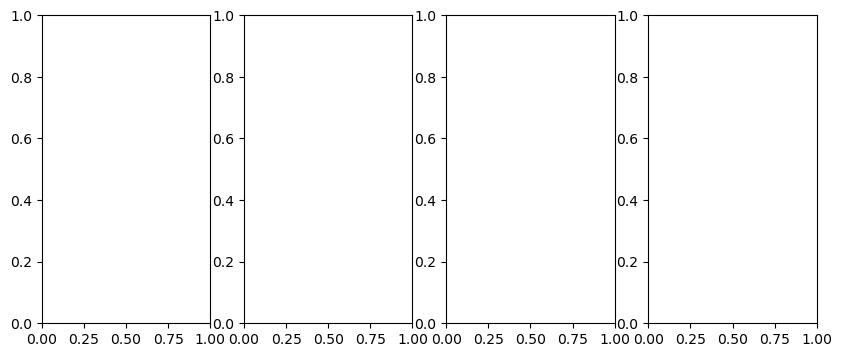

In [197]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 4, figsize=(10, 4))

In [198]:
import seaborn as sns

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_flux_distributions_by_pathway(pathway, cell_dict):
    """
    pathway: name of the pathway (string), used for the title
    cell_dict: { cell_line -> df(samples × reactions) } for this pathway
    """

    # ----------- Build combined long dataframe -----------
    long_frames = []

    for cell_line, df in cell_dict.items():
        df_long = df.melt(
            var_name="reaction",
            value_name="flux"
        )
        df_long["cell_line"] = cell_line
        long_frames.append(df_long)

    df_all = pd.concat(long_frames, ignore_index=True)

    # ----------- Get list of reactions --------------------
    reactions = df_all["reaction"].unique()
    n = len(reactions)

    # ----------- Create subplots --------------------------
    fig, axes = plt.subplots(
        1, n,
        figsize=(5 * n, 4),
        sharey=False
    )

    if n == 1:
        axes = [axes]

    # ----------- Plot each reaction -----------------------
    for ax, rxn in zip(axes, reactions):
        sub = df_all[df_all["reaction"] == rxn]

        # 🔹 variance per cell line for this reaction
        var_per_cell = sub.groupby("cell_line")["flux"].var()

        print(f"\n=== Reaction: {rxn} (pathway: {pathway}) ===")
        print(var_per_cell)

        # optional: highlight almost-constant ones
        very_small = var_per_cell[var_per_cell < 1e-10]
        if len(very_small) > 0:
            print("  -> Nearly constant in:", list(very_small.index))

        sns.kdeplot(
            data=sub,
            x="flux",
            hue="cell_line",
            fill=True,
            common_norm=False,
            ax=ax
        )

        ax.set_title(rxn)
        ax.set_xlabel("Flux")
        ax.set_ylabel("Density")

    plt.suptitle(f"Flux Distributions — {pathway}", fontsize=16)
    plt.tight_layout()
    plt.show()






=== Reaction: ACHEe (pathway: lipid) ===
cell_line
59M       5.316122e-17
CAOV3     1.244660e-18
COV318    1.580600e+01
HEYA8     0.000000e+00
OAW28     6.625532e-18
OV56      2.288127e+01
Name: flux, dtype: float64
  -> Nearly constant in: ['59M', 'CAOV3', 'HEYA8', 'OAW28']


C:\Users\iremu\AppData\Local\Temp\ipykernel_40704\568976554.py:53: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(



=== Reaction: HMR_0641 (pathway: lipid) ===
cell_line
59M       5.184130e-18
CAOV3     3.078644e-18
COV318    1.572399e-03
HEYA8     1.477731e-17
OAW28     5.782342e-19
OV56      3.878523e-01
Name: flux, dtype: float64
  -> Nearly constant in: ['59M', 'CAOV3', 'HEYA8', 'OAW28']

=== Reaction: HMR_0844 (pathway: lipid) ===
cell_line
59M       4.085935e-02
CAOV3     2.738978e-02
COV318    5.329221e-17
HEYA8     3.693877e+00
OAW28     1.321272e-01
OV56      6.967647e-02
Name: flux, dtype: float64
  -> Nearly constant in: ['COV318']

=== Reaction: ST6GALNAC62 (pathway: lipid) ===
cell_line
59M       1.287339e-02
CAOV3     6.612571e-04
COV318    5.446102e-19
HEYA8     7.932914e-03
OAW28     3.931219e-03
OV56      5.364465e-03
Name: flux, dtype: float64
  -> Nearly constant in: ['COV318']

=== Reaction: ST6GALNAC28 (pathway: lipid) ===
cell_line
59M       7.280357e-04
CAOV3     1.646710e-04
COV318    6.215680e-20
HEYA8     1.463871e-04
OAW28     3.350833e-03
OV56      3.529049e-03
Name: flu

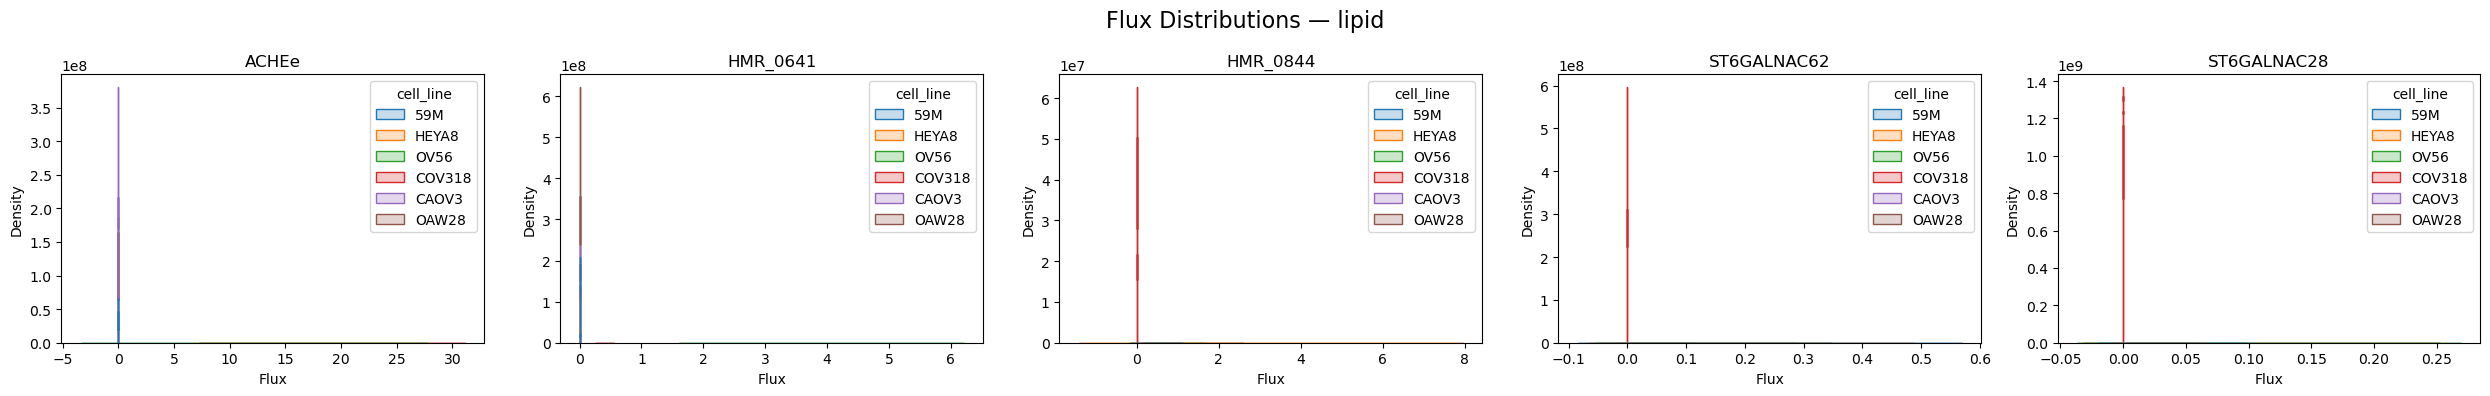


=== Reaction: GluForTx (pathway: amino_acid) ===
cell_line
59M       1.711909e+00
CAOV3     1.025589e-17
COV318    1.027933e+01
HEYA8     1.004713e-16
OAW28     2.801973e+00
OV56      3.543278e+00
Name: flux, dtype: float64
  -> Nearly constant in: ['CAOV3', 'HEYA8']

=== Reaction: 5HOXINOXDA (pathway: amino_acid) ===
cell_line
59M       2.045206e-33
CAOV3     5.216345e-13
COV318    6.356889e-02
HEYA8     1.207461e-42
OAW28     6.608599e-14
OV56      6.952853e-03
Name: flux, dtype: float64
  -> Nearly constant in: ['59M', 'CAOV3', 'HEYA8', 'OAW28']

=== Reaction: GHMT2r (pathway: amino_acid) ===
cell_line
59M       537.234384
CAOV3     323.702920
COV318    287.589830
HEYA8     575.439747
OAW28     197.964912
OV56      165.088762
Name: flux, dtype: float64

=== Reaction: r0145 (pathway: amino_acid) ===
cell_line
59M       0.111396
CAOV3     0.007088
COV318    0.000162
HEYA8     0.119371
OAW28     0.085558
OV56      0.000021
Name: flux, dtype: float64

=== Reaction: RE3201C (pathway: am

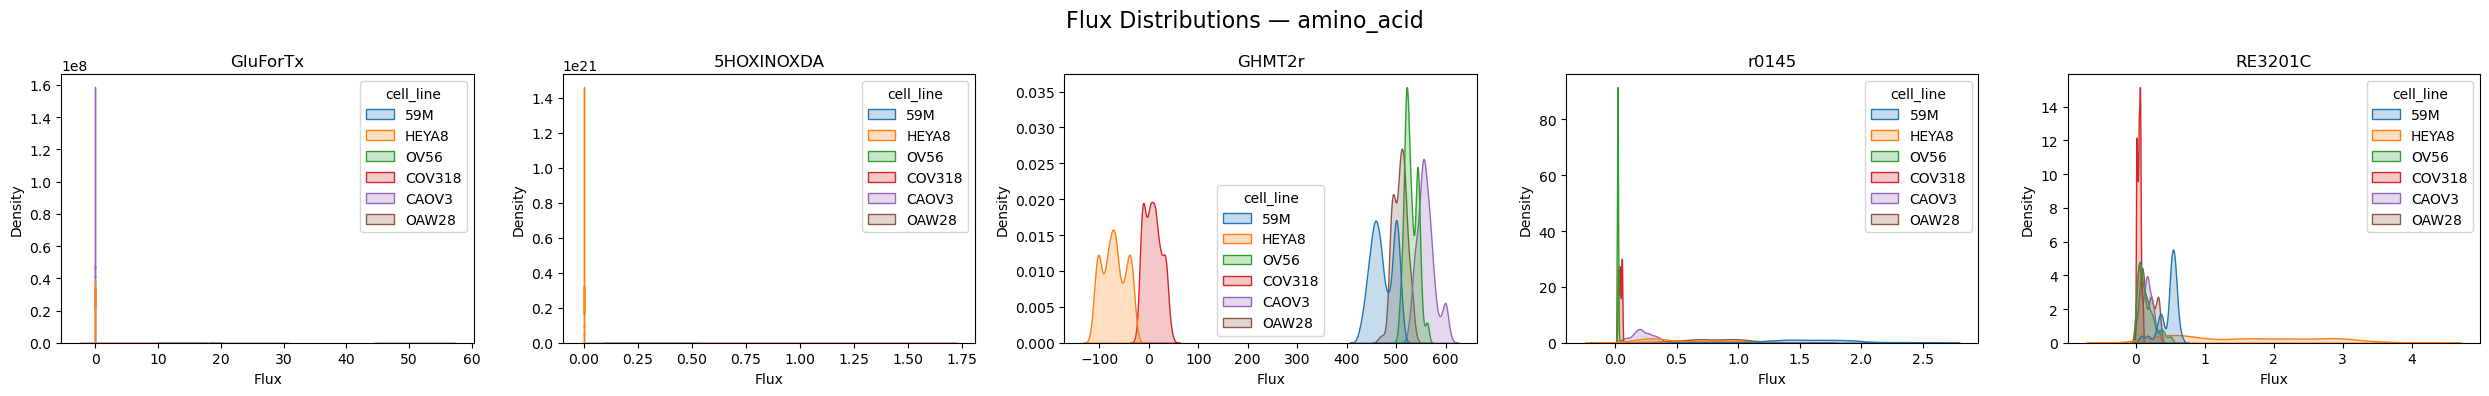


=== Reaction: 3HADICOAx (pathway: fatty_acid) ===
cell_line
59M       2.316780e-18
CAOV3     1.450126e-02
COV318    4.390405e-04
HEYA8     8.964507e-03
OAW28     1.773888e-18
OV56      3.886658e-02
Name: flux, dtype: float64
  -> Nearly constant in: ['59M', 'OAW28']

=== Reaction: 3HADPACx (pathway: fatty_acid) ===
cell_line
59M       2.316780e-18
CAOV3     1.450126e-02
COV318    4.390405e-04
HEYA8     8.964507e-03
OAW28     1.773888e-18
OV56      3.886658e-02
Name: flux, dtype: float64
  -> Nearly constant in: ['59M', 'OAW28']

=== Reaction: FAOXC12DCC10DCx (pathway: fatty_acid) ===
cell_line
59M       5.545262e-17
CAOV3     1.839647e-01
COV318    5.826403e-02
HEYA8     1.131106e-01
OAW28     2.612736e-17
OV56      2.247872e-01
Name: flux, dtype: float64
  -> Nearly constant in: ['59M', 'OAW28']

=== Reaction: FAOXC8DCC6DCx (pathway: fatty_acid) ===
cell_line
59M       1.149375e-17
CAOV3     1.038448e-01
COV318    2.080657e-03
HEYA8     6.357495e-02
OAW28     3.135451e-17
OV56      5

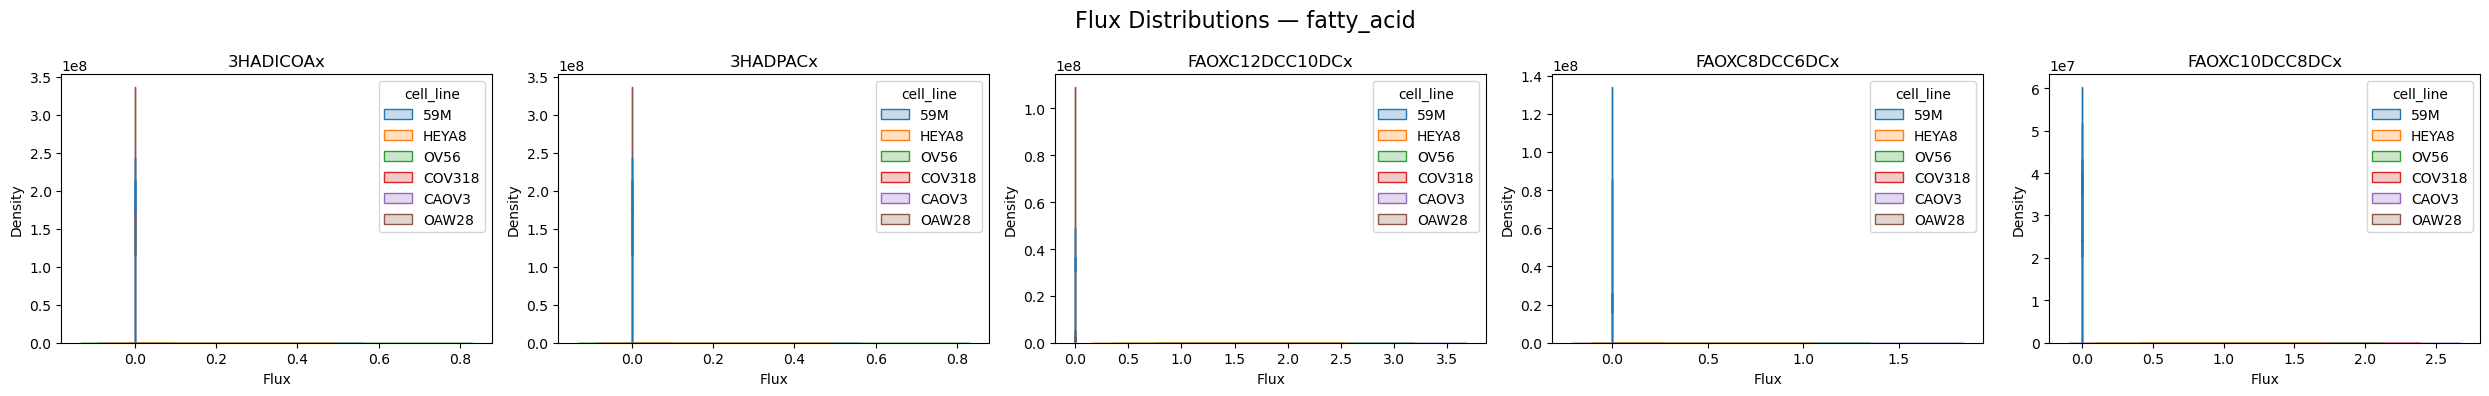


=== Reaction: BUP2 (pathway: nucleotide) ===
cell_line
59M       6.191035e-01
CAOV3     6.331710e-18
COV318    0.000000e+00
HEYA8     0.000000e+00
OAW28     1.234128e-17
OV56      6.801071e-01
Name: flux, dtype: float64
  -> Nearly constant in: ['CAOV3', 'COV318', 'HEYA8', 'OAW28']

=== Reaction: DHPM1 (pathway: nucleotide) ===
cell_line
59M       1.779027e-01
CAOV3     3.211517e-01
COV318    3.315100e-13
HEYA8     1.752385e-12
OAW28     3.845959e-01
OV56      5.512293e-01
Name: flux, dtype: float64
  -> Nearly constant in: ['COV318', 'HEYA8']


C:\Users\iremu\AppData\Local\Temp\ipykernel_40704\568976554.py:53: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(



=== Reaction: CYTK11n (pathway: nucleotide) ===
cell_line
59M       3067.702546
CAOV3     3343.840383
COV318     134.818469
HEYA8      921.161771
OAW28      697.110140
OV56       853.688850
Name: flux, dtype: float64

=== Reaction: r0330 (pathway: nucleotide) ===
cell_line
59M        414.700924
CAOV3      131.971612
COV318       0.176598
HEYA8     1340.178778
OAW28       75.739923
OV56       252.337813
Name: flux, dtype: float64

=== Reaction: DURADx (pathway: nucleotide) ===
cell_line
59M       261.590633
CAOV3     103.444907
COV318      0.299579
HEYA8     255.597295
OAW28      35.167072
OV56      213.101854
Name: flux, dtype: float64


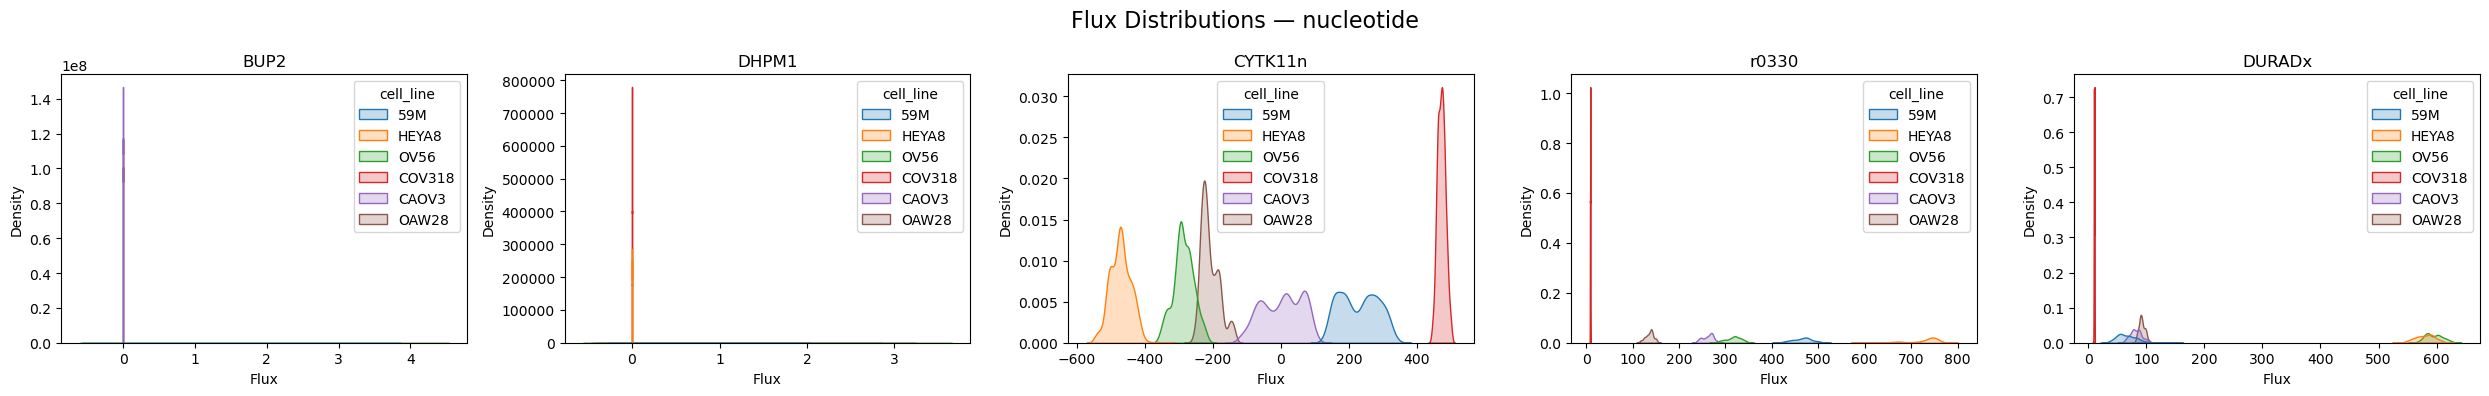


=== Reaction: LDH_L (pathway: glycolysis) ===
cell_line
59M        828.025759
CAOV3      433.246678
COV318     580.411233
HEYA8      877.976706
OAW28      431.502106
OV56      1143.940458
Name: flux, dtype: float64

=== Reaction: PGMT (pathway: glycolysis) ===
cell_line
59M       92.480712
CAOV3     79.509866
COV318    45.292223
HEYA8     68.163302
OAW28     99.515493
OV56      85.576209
Name: flux, dtype: float64

=== Reaction: PEPCK_re (pathway: glycolysis) ===
cell_line
59M       9.645532
CAOV3     3.243166
COV318    9.166006
HEYA8     0.000000
OAW28     6.651611
OV56      3.460768
Name: flux, dtype: float64
  -> Nearly constant in: ['HEYA8']

=== Reaction: PDHm (pathway: glycolysis) ===
cell_line
59M       21.278454
CAOV3     25.797031
COV318    58.819944
HEYA8     20.348951
OAW28     16.578670
OV56      37.285389
Name: flux, dtype: float64


C:\Users\iremu\AppData\Local\Temp\ipykernel_40704\568976554.py:53: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(



=== Reaction: HMR_7749 (pathway: glycolysis) ===
cell_line
59M        824.124228
CAOV3      471.317374
COV318     245.159385
HEYA8      135.850750
OAW28      782.207275
OV56      2149.385889
Name: flux, dtype: float64


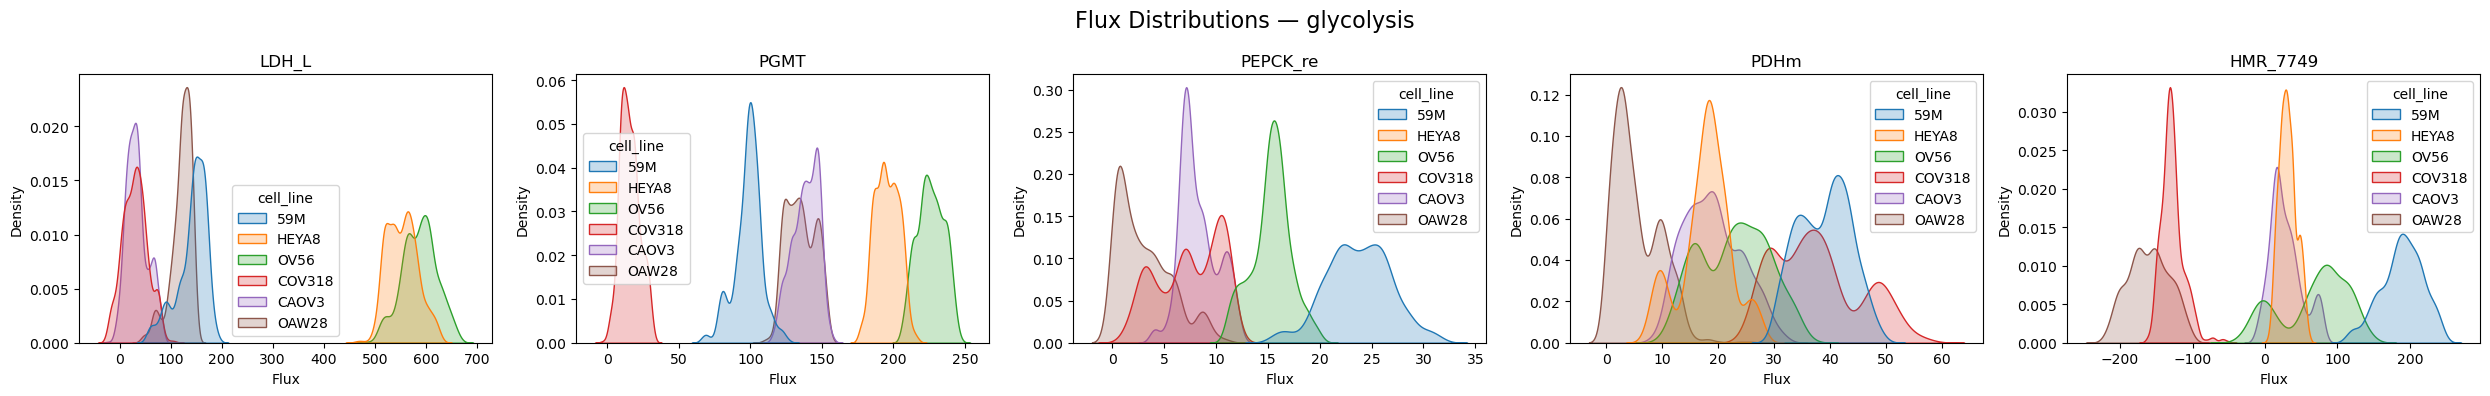


=== Reaction: UDPGNP (pathway: ppp) ===
cell_line
59M       1.873170
CAOV3     2.432177
COV318    0.144026
HEYA8     8.961907
OAW28     3.351681
OV56      7.568104
Name: flux, dtype: float64

=== Reaction: G6PDH2er (pathway: ppp) ===
cell_line
59M       1485.503182
CAOV3      584.041955
COV318     253.126810
HEYA8      316.447280
OAW28      273.961542
OV56       421.791020
Name: flux, dtype: float64

=== Reaction: PGLc (pathway: ppp) ===
cell_line
59M       2.796391
CAOV3     4.282952
COV318    0.519372
HEYA8     1.093228
OAW28     0.945649
OV56      0.887943
Name: flux, dtype: float64

=== Reaction: r0796 (pathway: ppp) ===
cell_line
59M       1.844448e-16
CAOV3     1.369003e-17
COV318    1.209275e-17
HEYA8     2.726721e-16
OAW28     5.216993e-18
OV56      9.871418e-17
Name: flux, dtype: float64
  -> Nearly constant in: ['59M', 'CAOV3', 'COV318', 'HEYA8', 'OAW28', 'OV56']

=== Reaction: DRBK (pathway: ppp) ===
cell_line
59M       7.545458
CAOV3     3.892794
COV318    0.662257
HEYA8  

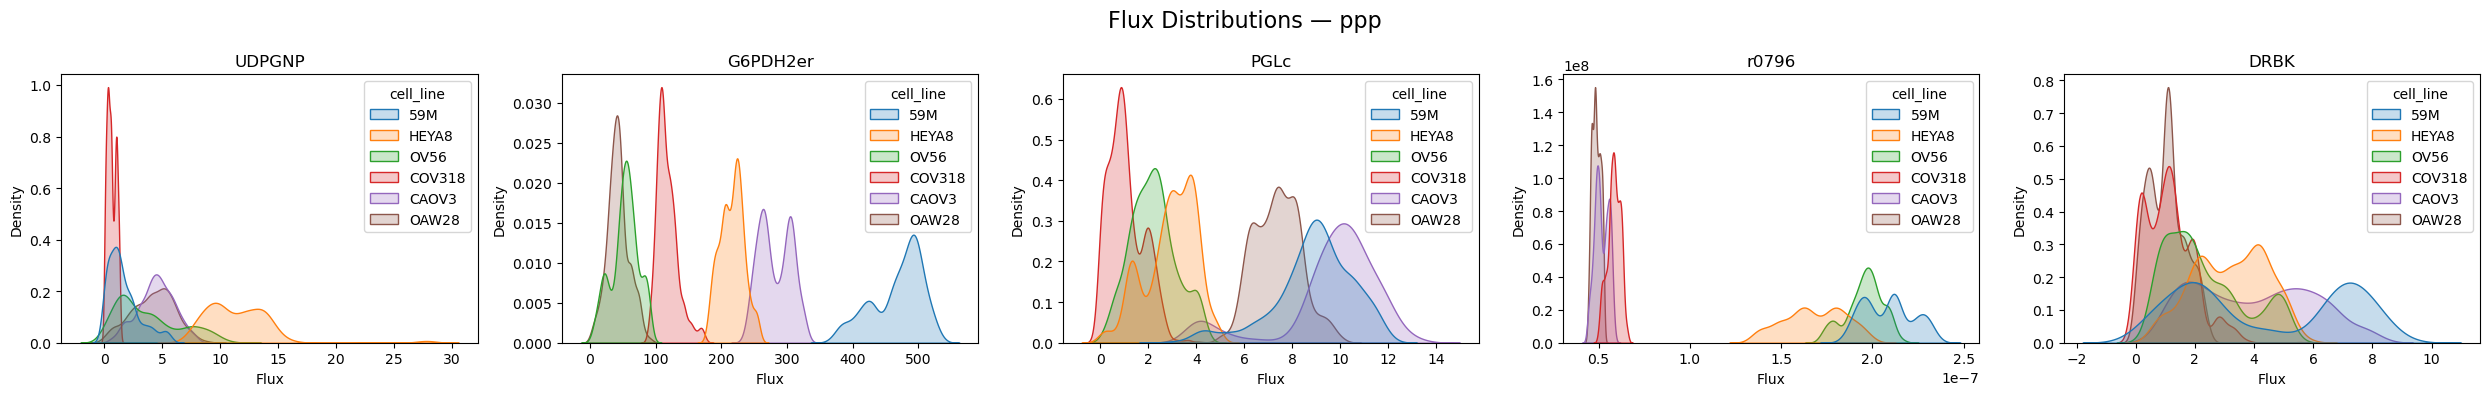


=== Reaction: ALATA_Lm (pathway: tca) ===
cell_line
59M        529.301258
CAOV3       60.660655
COV318      17.077854
HEYA8      310.722835
OAW28      174.869302
OV56      1222.463352
Name: flux, dtype: float64

=== Reaction: ACITL (pathway: tca) ===
cell_line
59M       0.896089
CAOV3     1.416580
COV318    0.558456
HEYA8     4.548811
OAW28     0.468996
OV56      1.831510
Name: flux, dtype: float64

=== Reaction: ICDHyp (pathway: tca) ===
cell_line
59M       35.793221
CAOV3     36.085416
COV318    28.413313
HEYA8     11.353905
OAW28     39.762008
OV56      17.018205
Name: flux, dtype: float64

=== Reaction: ICDHxm (pathway: tca) ===
cell_line
59M        760.298137
CAOV3      251.201709
COV318     164.544857
HEYA8      178.445512
OAW28     1237.949769
OV56       128.266191
Name: flux, dtype: float64

=== Reaction: CSm (pathway: tca) ===
cell_line
59M        72.381106
CAOV3      56.870019
COV318     69.926586
HEYA8     109.638386
OAW28      72.211339
OV56       78.588636
Name: flux, dty

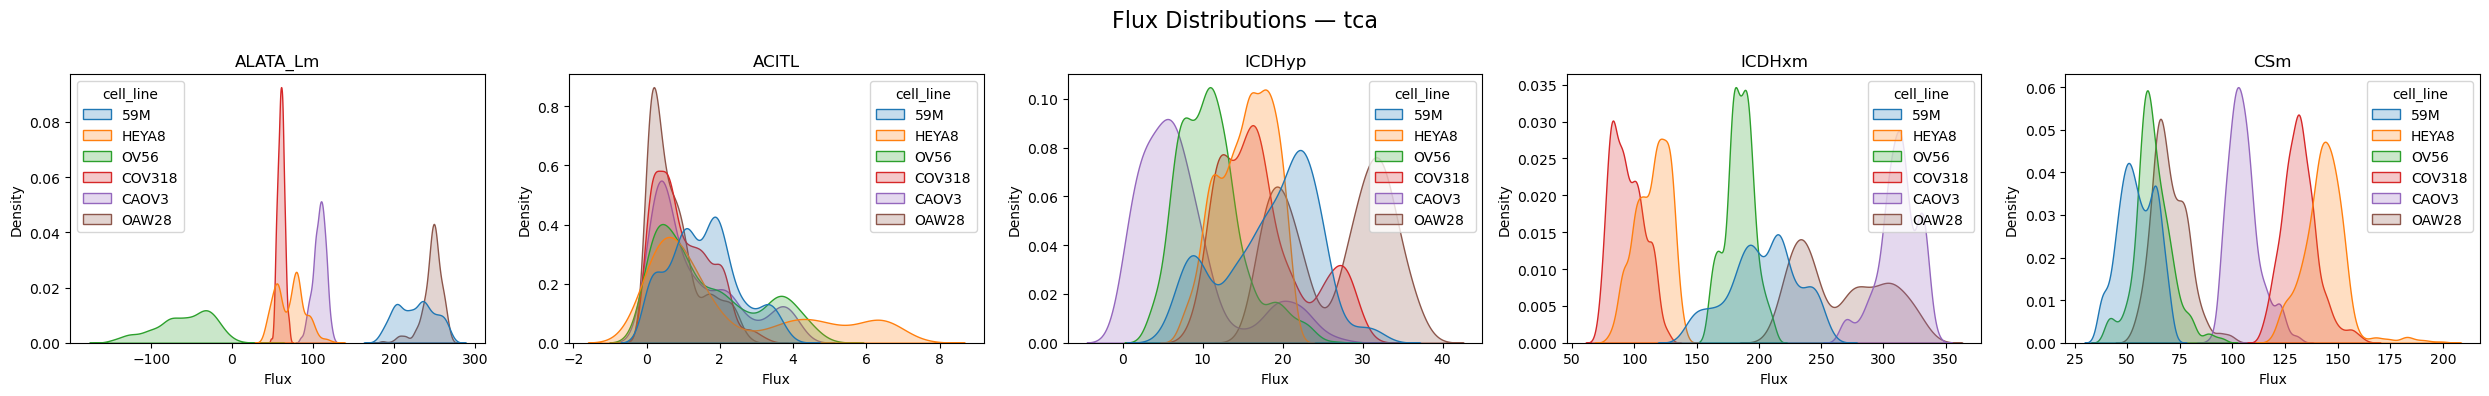

In [203]:
for pathway, cell_dict in pathway_dicts.items():
    plot_flux_distributions_by_pathway(pathway, cell_dict)



In [201]:
sns.displot(df_long, x="flux", hue="cell_line", kind="kde")

ValueError: Could not interpret value `cell_line` for `hue`. An entry with this name does not appear in `data`.